In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from matplotlib import gridspec

from sklearn.preprocessing import scale

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from sklearn.utils import shuffle
from scipy.special import softmax

from PIL import Image

from PIL import ImageDraw

from skimage import morphology

import pickle

In [2]:
lang = 'ru'

In [3]:
folder_result = 'result'

In [4]:
plt.rcParams["font.family"] = 'Djvu Serif'

plt.rcParams['text.latex.unicode'] = True

In [5]:
plt.rcParams['text.usetex'] = False

In [6]:
plt.rcParams['text.latex.preamble'] = [r'\usepackage[utf8x]{inputenc}', 
                                       r'\usepackage[english,russian]{babel}', 
                                       r'\usepackage{amsmath}']

In [7]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [8]:
color = ['black', 'gray', 'black', 'black', 'black']
color = ['blue', 'red', 'black', 'black', 'black']
marker = ['^', 's', 'v', 'D', 'P']

In [9]:
from MixtureLib.Mixture import MixtureEM
from MixtureLib.LocalModels import EachModelLinear
from MixtureLib.HyperModels import HyperExpertNN

from MixtureLib.Regularizers import RegularizeModel

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Statement Picture

In [10]:
List_of_Data_Name = ['Data/1.csv', 'Data/2.csv', 'Data/3.csv']

List_of_Data = []

for NAME in List_of_Data_Name:
    data = pd.read_csv(NAME)
    x, y = np.array(data).T
    List_of_Data.append([x,y])

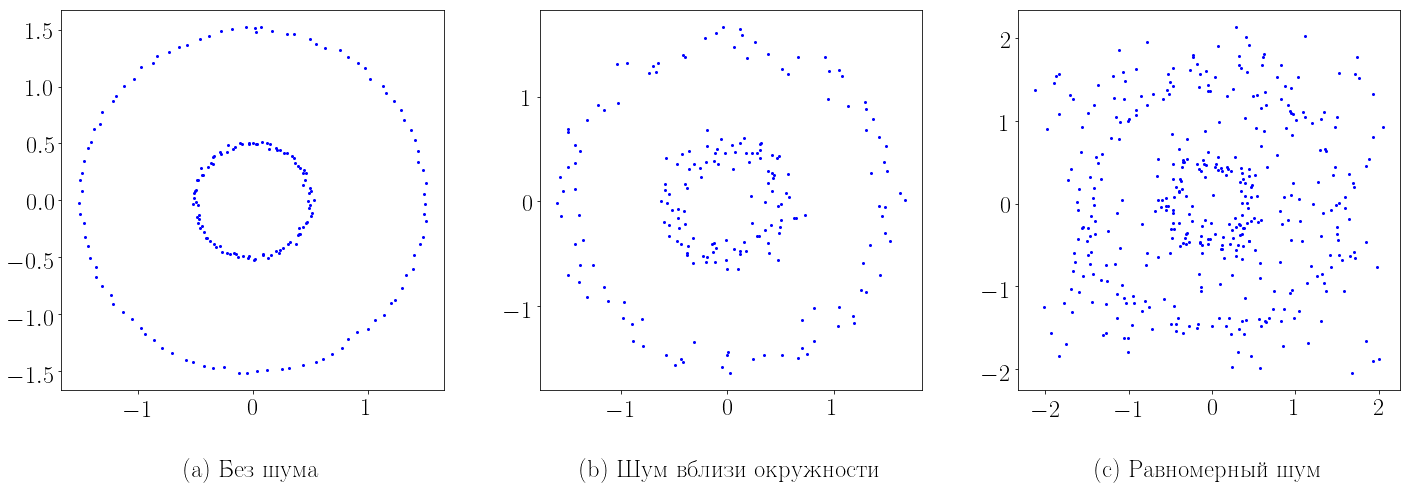

In [11]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 7.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color


fig = plt.figure();

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

ax = [] 
for k in range(3):
    ax.append(fig.add_subplot(gs[k]))

if lang == 'eng':
    cols = ['Without noise', 'Noise near circle', 'Uniform noise']
elif lang == 'ru':
    cols = ['Без шума', 'Шум вблизи окружности', 'Равномерный шум']

TITLE = ['(a)', '(b)', '(c)']

#------___1___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]

#     ax[k].set_xlabel('$x$')
#     ax[k].set_ylabel('$y$')
    
    _ = ax[k].plot(x, y, '.', color = colors[0])
    ax[k].set_title(TITLE[k] + ' ' + cols[k], y=-0.24)
        


plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig('./' + folder_result+ '/statment.pdf', bbox_inches='tight')

plt.show()

## Computation experiment (Synthetick)

In [12]:
List_of_Data_Name = ['Data/1.csv', 'Data/2.csv', 'Data/3.csv']

List_of_Data = []

for NAME in List_of_Data_Name:
    data = pd.read_csv(NAME)
    x, y = np.array(data).T
    List_of_Data.append([x,y])

In [13]:
K = 2
n = 3

epoch = 25

In [14]:
List_of_Data_Prior = []
List_of_Prior_model = []

for k in range(len(List_of_Data)):

    x, y = List_of_Data[k]
    X = np.vstack([x, y, np.ones_like(x)]).T
    Y = x**2+y**2

    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])

    LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
    LIST_w = [torch.Tensor([[0], [0], [0.1]]), torch.Tensor([[0], [0], [2]])]

    LoM = []
    for k in range(K):
        LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

    HypPar = {'beta': 1.0}
    HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

    model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)
    model.fit(X_tr, Y_tr, epoch, progress = tqdm)

    idx = np.argmax(model.predict(X_tr)[1], axis = 1)
    
    List_of_Data_Prior.append(idx)
    List_of_Prior_model.append(model)



In [15]:
List_of_Data_Non_Prior = []
List_of_Non_Prior_model = []

for k in range(len(List_of_Data)):

    x, y = List_of_Data[k]
    X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
    Y = x**2+y**2

    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])
    
    LoM = []
    for k in range(K):
        LoM.append(EachModelLinear(input_dim = n, device = device))

    HypPar = {'beta': 1.0}
    HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

    model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)
    model.fit(X_tr, Y_tr, epoch, progress = tqdm)

    idx = np.argmax(model.predict(X_tr)[1], axis = 1)
    
    List_of_Data_Non_Prior.append(idx)
    List_of_Non_Prior_model.append(model)


In [16]:
List_of_Data_Regular_Prior = []
List_of_Regular_Prior_model = []

for k in range(len(List_of_Data)):

    x, y = List_of_Data[k]
    X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
    Y = x**2+y**2

    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])
    
    LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
    LIST_w = [torch.Tensor([[0], [0], [0.1]]), torch.Tensor([[0], [0], [2]])]
    
    LoM = []
    for k in range(K):
        LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

    HypPar = {'beta': 1.0, 'alpha': 1}
    HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

    model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [RegularizeModel(ListOfModels = LoM)], device = device)
    model.fit(X_tr, Y_tr, epoch, progress = tqdm)

    idx = np.argmax(model.predict(X_tr)[1], axis = 1)
    
    List_of_Data_Regular_Prior.append(idx)
    List_of_Regular_Prior_model.append(model)



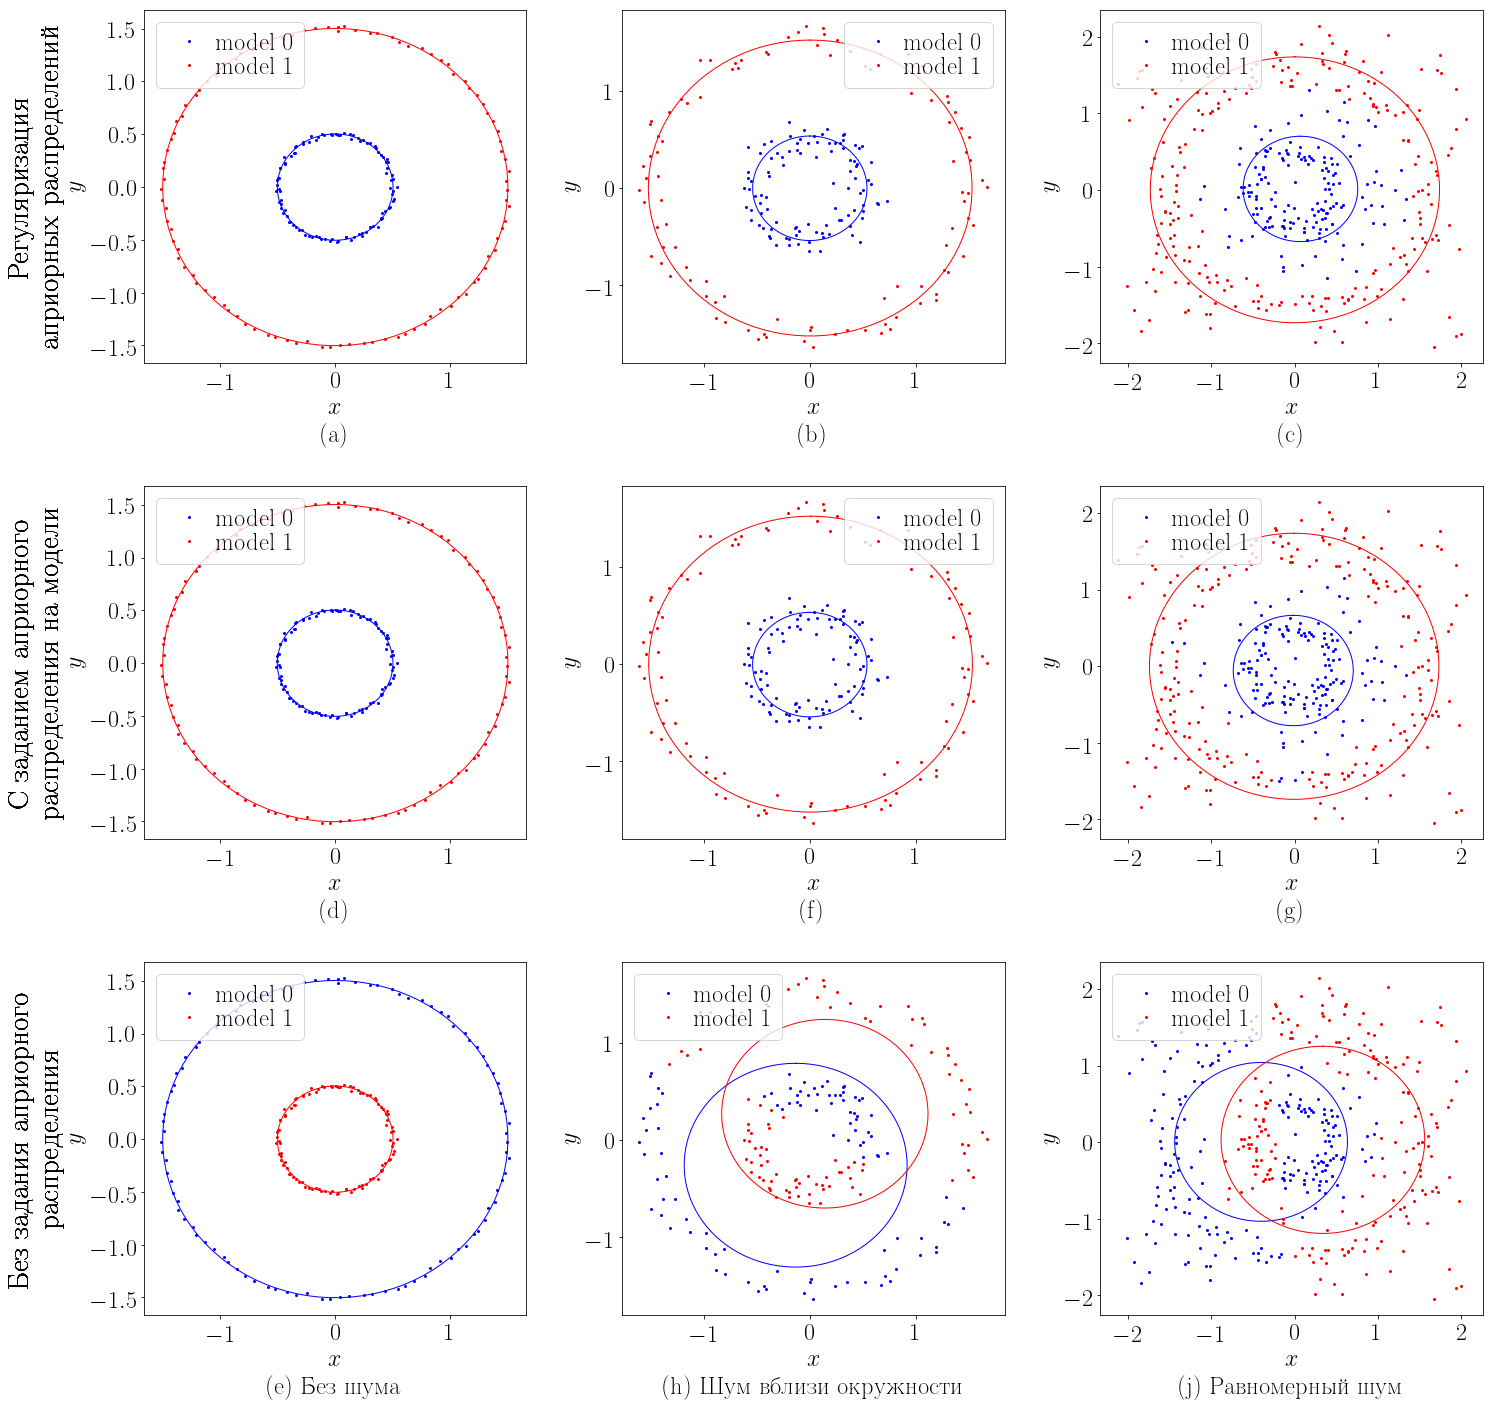

In [17]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 24.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color


fig = plt.figure();

gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1])

ax1 = [] 
for k in range(3):
    ax1.append(fig.add_subplot(gs[k]))
    
ax2 = [] 
for k in range(3, 6):
    ax2.append(fig.add_subplot(gs[k]))
    
ax3 = [] 
for k in range(6, 9):
    ax3.append(fig.add_subplot(gs[k]))
    
if lang == 'eng':
    cols = ['Without noise', 'Noise near circle', 'Uniform noise']
elif lang == 'ru':
    cols = ['Без шума', 'Шум вблизи окружности', 'Равномерный шум']
    
if lang == 'eng':
    rows = ['With prior regular', 'With prior', 'Without prior']
elif lang == 'ru':
    rows = ['Регуляризация\nаприорных распределений', 'C заданием априорного\nраспределения на модели', 'Без задания априорного\nраспределения']  

TITLE = ['(a)', '(b)', '(c)']
    
#------___1___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]
    idx = List_of_Data_Regular_Prior[k]
    
    model = List_of_Regular_Prior_model[k]
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])
    CIRCLE = np.zeros_like(TEMP)

    ax1[k].set_xlabel('$x$')
    ax1[k].set_ylabel('$y$')
    
    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r

    for i in np.unique(idx):
        _ = ax1[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax1[k].plot(x_plot, y_plot, '-', color = colors[i])
        ax1[k].legend(loc = 'best')
        
        ax1[k].set_title(TITLE[k], y=-0.24)
        
        ax1[0].annotate(rows[0], xy=(0, 0.5), xytext=(-ax1[0].yaxis.labelpad - 24, 0),
                        xycoords=ax1[0].yaxis.label, textcoords='offset points',
                        size='large', ha='center', va='center', rotation=90)

TITLE = ['(d)', '(f)', '(g)']
        
#------___2___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]
    idx = List_of_Data_Prior[k]
    
    model = List_of_Prior_model[k]
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])
    CIRCLE = np.zeros_like(TEMP)

    ax2[k].set_xlabel('$x$')
    ax2[k].set_ylabel('$y$')
    
    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r

    for i in np.unique(idx):
        _ = ax2[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax2[k].plot(x_plot, y_plot, '-', color = colors[i])
        ax2[k].legend(loc = 'best')
        
        ax2[k].set_title(TITLE[k], y=-0.24)
        
        ax2[0].annotate(rows[1], xy=(0, 0.5), xytext=(-ax2[0].yaxis.labelpad - 24, 0),
                        xycoords=ax2[0].yaxis.label, textcoords='offset points',
                        size='large', ha='center', va='center', rotation=90)

TITLE = ['(e)', '(h)', '(j)']
        
#------___3___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]
    idx = List_of_Data_Non_Prior[k]
    
    model = List_of_Non_Prior_model[k]
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])
    CIRCLE = np.zeros_like(TEMP)
    
    ax3[k].set_xlabel('$x$')
    ax3[k].set_ylabel('$y$')

    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r

    for i in np.unique(idx):
        _ = ax3[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax3[k].plot(x_plot, y_plot, '-', color = colors[i])
        ax3[k].legend(loc = 'best')
        ax3[k].set_title(TITLE[k] + ' ' + cols[k], y=-0.24)
    
        ax3[0].annotate(rows[2], xy=(0, 0.5), xytext=(-ax3[0].yaxis.labelpad - 24, 0),
                        xycoords=ax3[0].yaxis.label, textcoords='offset points',
                        size='large', ha='center', va='center', rotation=90)
    
# plt.grid()

plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig('./' + folder_result + '/experiment_synthetic.pdf', bbox_inches='tight')

plt.show()

# Picture in Experiment with real Data

In [18]:
image = Image.open('Picture/1.tif')

mask_1 = Image.open('Picture/1_mask_2.jpg').convert('L')
mask_1 = Image.fromarray((255*(np.array(mask_1) > 125)).astype(np.uint8))

In [19]:
x = np.array(np.where(np.array(mask_1) > 0)[1], dtype = np.float)
y = np.array(mask_1.size[0]-np.where(np.array(mask_1) > 0)[0], dtype = np.float)

x = scale(x)
y = scale(y)

x, y = shuffle(x, y, random_state = 0)

x = x[:200]
y = y[:200]

X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([200, 3]), torch.Size([200, 1]))

In [20]:
def extract_picture(model):
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

    CIRCLE = np.zeros_like(TEMP)

    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r
        
    idx = np.argmax(model.predict(X_tr)[1], axis = 1)
    
    return CIRCLE, idx

In [51]:
K = 2
n = 3

epoch = 25

In [52]:
%%time

LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]


LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

HypPar = {'beta': 1.0}

HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)


List_of_step_Prior = []
for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_step_Prior.append(extract_picture(model))


CPU times: user 1min 1s, sys: 939 ms, total: 1min 2s
Wall time: 1min 4s


In [48]:
%%time

LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0.0], [0.0], [1]]), torch.Tensor([[0.0], [0.0], [2]])]


LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

HypPar = {'beta': 1.0, 'alpha': 1e-5}

HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)
Rg = RegularizeModel(ListOfModels = LoM, device = device)
model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [Rg], device = device)

List_of_step_Prior_Regular = []
for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_step_Prior_Regular.append(extract_picture(model))



CPU times: user 56.4 s, sys: 648 ms, total: 57 s
Wall time: 57.4 s


In [24]:
%%time

LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device))

HypPar = {'beta': 1.0}

HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)


List_of_step_Not_Prior = []
for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_step_Not_Prior.append(extract_picture(model))





CPU times: user 54 s, sys: 560 ms, total: 54.5 s
Wall time: 54.8 s


In [53]:
List_of_answers_comparing = [List_of_step_Not_Prior[-1], List_of_step_Prior[-1], List_of_step_Prior_Regular[-1]]

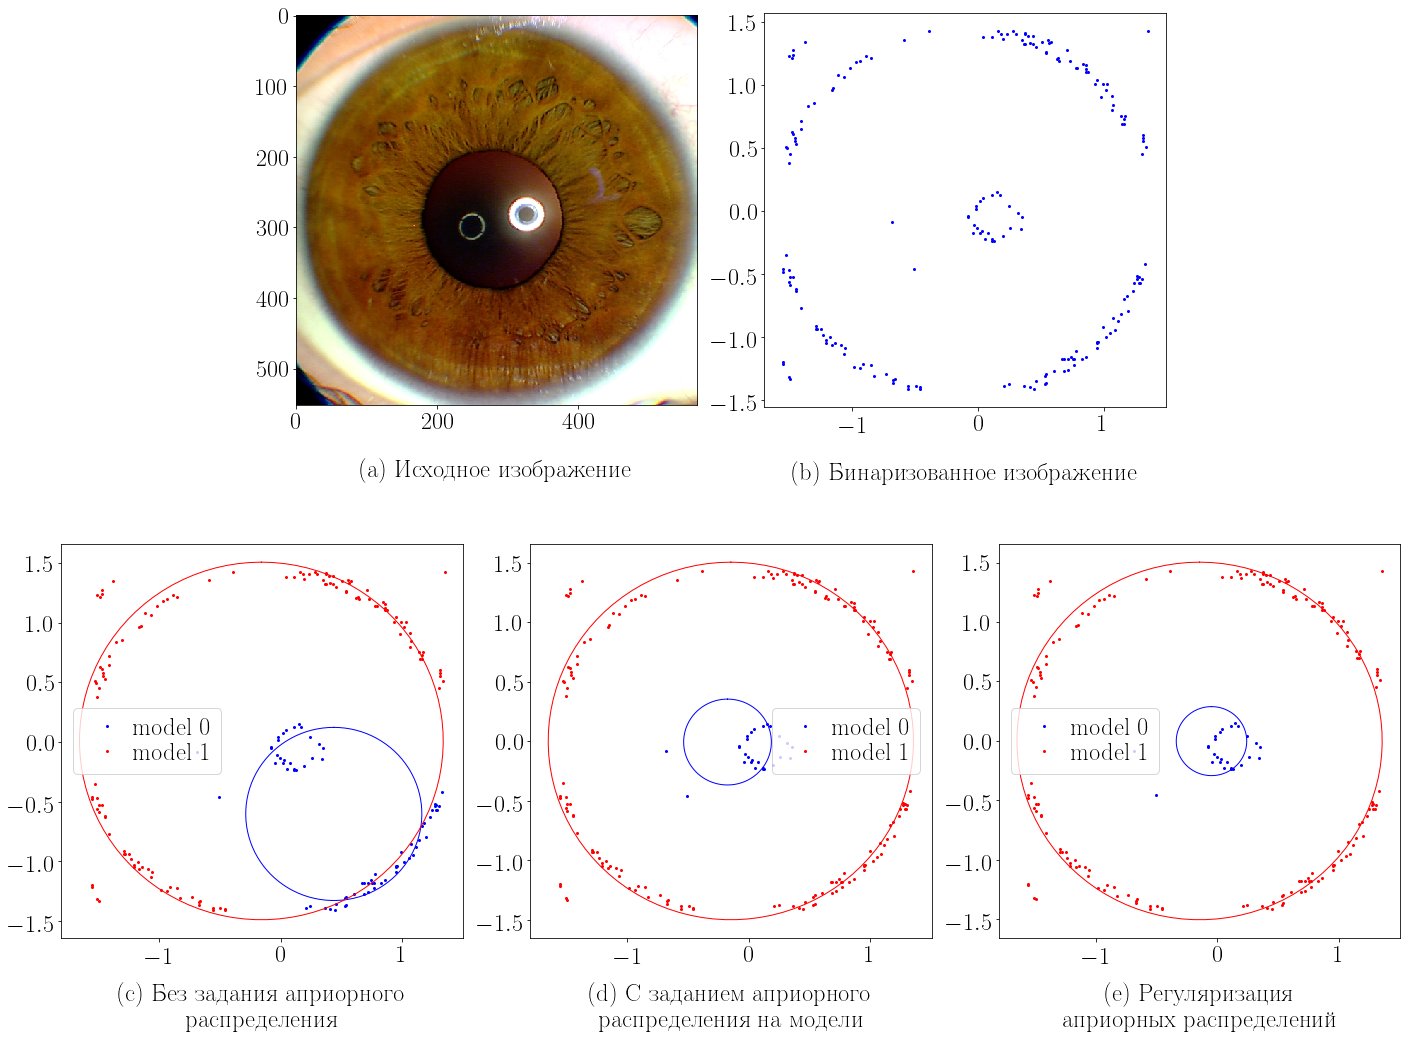

In [54]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 17.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color


fig = plt.figure();

gs = gridspec.GridSpec(2, 6, width_ratios=[1,1,1,1,1,1], height_ratios=[1,1])

ax1 = [] 
ax2 = []

ax1.append(fig.add_subplot(gs[0, 1:3]))
ax1.append(fig.add_subplot(gs[0, 3:5]))

ax2.append(fig.add_subplot(gs[1, 0:2]))
ax2.append(fig.add_subplot(gs[1, 2:4]))
ax2.append(fig.add_subplot(gs[1, 4:6]))
    
# ------------1------------
if lang == 'eng':
    cols = ['Real image', 'Binar image']
elif lang == 'ru':
    cols = ['Исходное изображение', 'Бинаризованное изображение']
    
TITLE = ['(a)', '(b)']

for k in range(len(ax1)):
    ax1[k].set_title(TITLE[k] + ' ' + cols[k], y=-0.2)
# Real image
k = 0
ax1[k].imshow(image)

# mask with iris circle
k = 1
ax1[k].plot(x, y, '.', color = color[0])

# ------------2------------
if lang == 'eng':
    cols = ['With prior regular', 'With prior', 'Without prior']
elif lang == 'ru':
    cols = ['Без задания априорного\nраспределения', 'C заданием априорного\nраспределения на модели', 'Регуляризация\nаприорных распределений']  

TITLE = ['(c)', '(d)', '(e)']

for k in range(len(ax2)):
    ax2[k].set_title(TITLE[k] + ' ' + cols[k], y=-0.24)
# Real image
for k in range(len(List_of_answers_comparing)):
    CIRCLE, idx = List_of_answers_comparing[k]
    for i in np.unique(idx):
        _ = ax2[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax2[k].plot(x_plot, y_plot, '-', color = colors[i])
        ax2[k].legend(loc = 'best')



plt.subplots_adjust(wspace=0.4, hspace=0.35)
plt.savefig('./' + folder_result + '/experiment_real_compare.pdf', bbox_inches='tight')

plt.show()

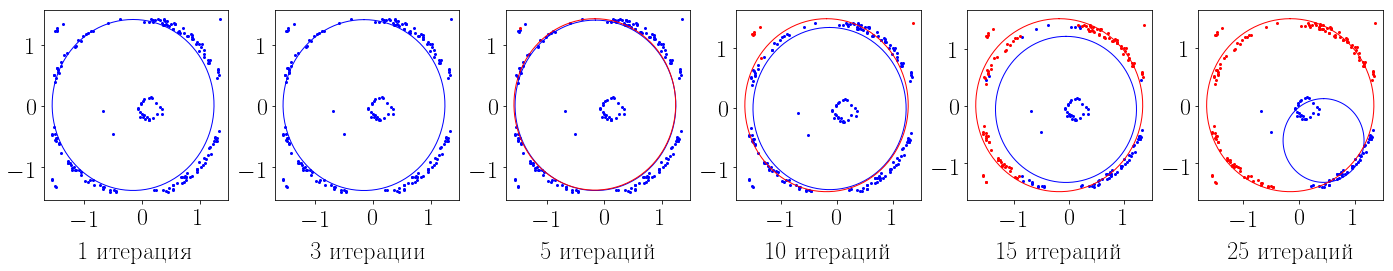

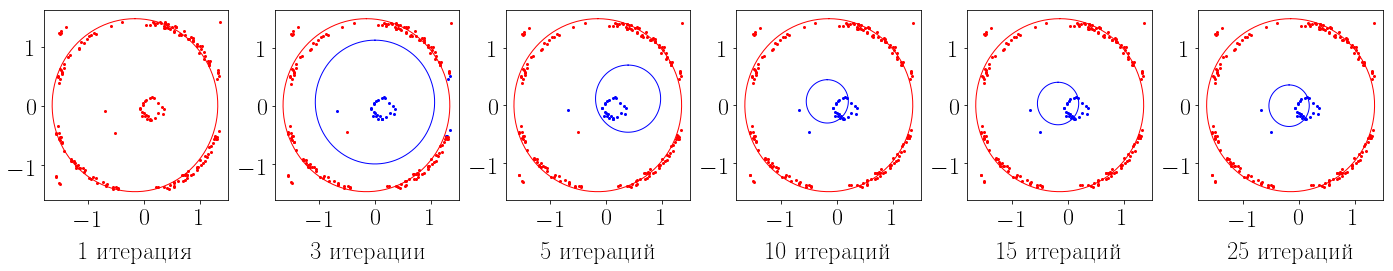

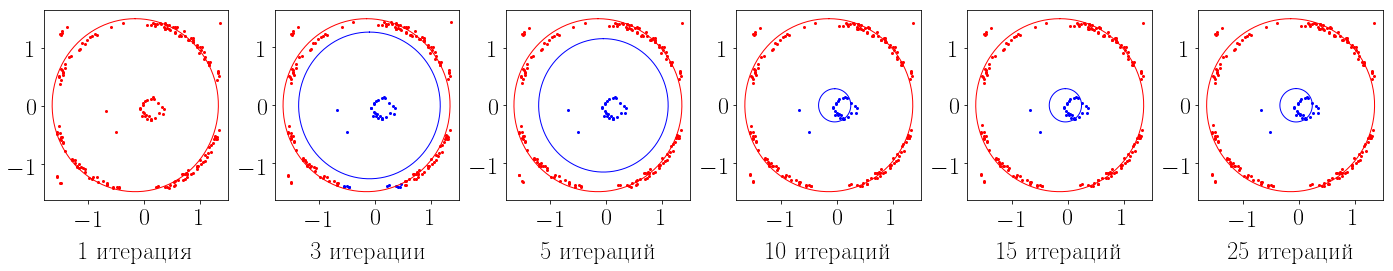

In [57]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 3.5)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

epochs = [1, 3, 5, 10, 15, 25]

t = np.linspace(0, 2*np.pi, 100)

colors = color

    
if lang == 'eng':
    rows = ['With prior regular', 'With prior', 'Without prior']
elif lang == 'ru':
    rows = ['Без задания априорного распределения', 'C заданием априорного распределения на модели', 'Регуляризация априорных распределений']  

if lang == 'eng':
    cols = [str(e) + 'epoch' for e in epochs]
elif lang == 'ru':
    cols = ['1 итерация', '3 итерации', '5 итераций', '10 итераций', '15 итераций', '25 итераций']


# -----------------1---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(epochs)):
    ax.append(fig.add_subplot(gs[k]))
    
for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)

List_of_step = [(List_of_step_Not_Prior[k - 1], k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])


plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('./' + folder_result + '/experiment_real_not_prior.pdf', bbox_inches='tight')
plt.show()    
    
# -----------------2---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(List_of_step)):
    ax.append(fig.add_subplot(gs[k]))

for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)
    
List_of_step = [(List_of_step_Prior[k - 1], k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('./' + folder_result + '/experiment_real_prior.pdf', bbox_inches='tight')
plt.show()

# -----------------3---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(List_of_step)):
    ax.append(fig.add_subplot(gs[k]))

for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)
    
List_of_step = [(List_of_step_Prior_Regular[k - 1], k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('./' + folder_result + '/experiment_real_regular.pdf', bbox_inches='tight')
plt.show()

# Experiment with likelihood proccesing

In [11]:
def extract_picture(model, only_circ=False):
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

    CIRCLE = np.zeros_like(TEMP)

    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r
    
    if only_circ:
        idx = None
    else:
        idx = np.argmax(model.predict(X_tr)[1], axis = 1)
    
    return CIRCLE, idx

def log_likelihood(Y, X, model):
    """
        Args:
            X: Tensor, has a shape batch_size x n
            Y: Tensor, has a shape batch_size x 1
            model: mixture of experts model
        
        Returns:
            log likelihood without prior
    """
    pi = F.softmax(model.HyperModel(X), dim = -1)
    m = torch.cat([model.ListOfModels[0](X), model.ListOfModels[1](X)], dim = 1)
    
    
    return torch.logsumexp(torch.log(pi)*2.0/(model.HyperParameters['beta'] + 1e-15)*((Y_tr-m)**2), dim = 1).mean().item()

In [12]:
data = pd.read_csv('Data/3.csv')
x, y = np.array(data).T

In [13]:
X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([400, 3]), torch.Size([400, 1]))

In [14]:
K = 2
n = 3

epoch = 25

k_for_meaning = 10

In [15]:
# %%time

# LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
# LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]

# List_of_log_likehoods_Prior = []
# List_of_circles_Prior = []
# List_of_idxs_Prior = []

# for _ in tqdm(range(k_for_meaning)):

#     LoM = []
#     for k in range(K):
#         LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

#     HypPar = {'beta': 1.0}

#     HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

#     model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)

#     List_of_log_likehood_Prior = [log_likelihood(Y_tr, X_tr, model)]
#     List_of_circle_Prior = [extract_picture(model, only_circ=True)[0]]
#     List_of_idx_Prior = [None]
    
#     for _ in tqdm(range(epoch), leave = False):
#         model.fit(X_tr, Y_tr, 1, progress = None)
#         List_of_log_likehood_Prior.append(log_likelihood(Y_tr, X_tr, model))
#         CIRCLES, IDX = extract_picture(model, only_circ=False)
#         List_of_circle_Prior.append(CIRCLES)
#         List_of_idx_Prior.append(IDX)
        

#     List_of_log_likehoods_Prior.append(List_of_log_likehood_Prior)
#     List_of_circles_Prior.append(List_of_circle_Prior)
#     List_of_idxs_Prior.append(List_of_idx_Prior)

# List_of_log_likehoods_Prior = np.array(List_of_log_likehoods_Prior)
# List_of_circles_Prior = np.array(List_of_circles_Prior)
# List_of_idxs_Prior = np.array(List_of_idxs_Prior)

# List_of_log_likehood_Prior_mean = np.mean(List_of_log_likehoods_Prior, axis = 0)
# List_of_log_likehood_Prior_std = np.std(List_of_log_likehoods_Prior, axis = 0)

# pickle.dump([List_of_log_likehood_Prior_mean, List_of_log_likehood_Prior_std, List_of_log_likehoods_Prior, List_of_circles_Prior, List_of_idxs_Prior], open('./dump/prior.pkl', 'wb'))


In [16]:
List_of_log_likehood_Prior_mean, List_of_log_likehood_Prior_std, List_of_log_likehoods_Prior, List_of_circles_Prior, List_of_idxs_Prior = pickle.load(open('./dump/prior.pkl', 'rb'))


In [17]:
# %%time

# LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
# LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]

# List_of_log_likehoods_Prior_Regular = []
# List_of_circles_Prior_Regular = []
# List_of_idxs_Prior_Regular = []

# for _ in tqdm(range(k_for_meaning)):

#     LoM = []
#     for k in range(K):
#         LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

#     HypPar = {'beta': 1.0, 'alpha': 1e-5}

#     HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)
#     Rg = RegularizeModel(ListOfModels = LoM, device = device)
#     model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [Rg], device = device)

#     List_of_log_likehood_Prior_Regular = [log_likelihood(Y_tr, X_tr, model)]
#     List_of_circle_Prior_Regular = [extract_picture(model, only_circ=True)[0]]
#     List_of_idx_Prior_Regular = [None]
    
#     for _ in tqdm(range(epoch), leave = False):
#         model.fit(X_tr, Y_tr, 1, progress = None)
#         List_of_log_likehood_Prior_Regular.append(log_likelihood(Y_tr, X_tr, model))
#         CIRCLES, IDX = extract_picture(model, only_circ=False)
#         List_of_circle_Prior_Regular.append(CIRCLES)
#         List_of_idx_Prior_Regular.append(IDX)

#     List_of_log_likehoods_Prior_Regular.append(List_of_log_likehood_Prior_Regular)
#     List_of_circles_Prior_Regular.append(List_of_circle_Prior_Regular)
#     List_of_idxs_Prior_Regular.append(List_of_idx_Prior_Regular)

# List_of_log_likehoods_Prior_Regular = np.array(List_of_log_likehoods_Prior_Regular)
# List_of_circles_Prior_Regular = np.array(List_of_circles_Prior_Regular)
# List_of_idxs_Prior_Regular = np.array(List_of_idxs_Prior_Regular)

# List_of_log_likehood_Prior_Regular_mean = np.mean(List_of_log_likehoods_Prior_Regular, axis = 0)
# List_of_log_likehood_Prior_Regular_std = np.std(List_of_log_likehoods_Prior_Regular, axis = 0)

# pickle.dump([List_of_log_likehood_Prior_Regular_mean, List_of_log_likehood_Prior_Regular_std, List_of_log_likehoods_Prior_Regular, List_of_circles_Prior_Regular, List_of_idxs_Prior_Regular], open('./dump/prior_regular.pkl', 'wb'))



In [18]:
List_of_log_likehood_Prior_Regular_mean, List_of_log_likehood_Prior_Regular_std, List_of_log_likehoods_Prior_Regular, List_of_circles_Prior_Regular, List_of_idxs_Prior_Regular = pickle.load(open('./dump/prior_regular.pkl', 'rb'))


In [19]:
# %%time

# List_of_log_likehoods_Not_Prior = []
# List_of_circles_Not_Prior = []
# List_of_idxs_Not_Prior = []

# for _ in tqdm(range(k_for_meaning)):

#     LoM = []
#     for k in range(K):
#         LoM.append(EachModelLinear(input_dim = n, device = device))

#     HypPar = {'beta': 1.0}

#     HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

#     model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)


#     List_of_log_likehood_Not_Prior = [log_likelihood(Y_tr, X_tr, model)]
#     List_of_circle_Not_Prior = [extract_picture(model, only_circ=True)[0]]
#     List_of_idx_Not_Prior = [None]
    
#     for _ in tqdm(range(epoch), leave = False):
#         model.fit(X_tr, Y_tr, 1, progress = None)
#         List_of_log_likehood_Not_Prior.append(log_likelihood(Y_tr, X_tr, model))
#         CIRCLES, IDX = extract_picture(model, only_circ=False)
#         List_of_circle_Not_Prior.append(CIRCLES)
#         List_of_idx_Not_Prior.append(IDX)
        
#     List_of_log_likehoods_Not_Prior.append(List_of_log_likehood_Not_Prior)
#     List_of_circles_Not_Prior.append(List_of_circle_Not_Prior)
#     List_of_idxs_Not_Prior.append(List_of_idx_Not_Prior)
    
# List_of_log_likehoods_Not_Prior = np.array(List_of_log_likehoods_Not_Prior)
# List_of_circles_Not_Prior = np.array(List_of_circles_Not_Prior)
# List_of_idxs_Not_Prior = np.array(List_of_idxs_Not_Prior)

# List_of_log_likehood_Not_Prior_mean = np.mean(List_of_log_likehoods_Not_Prior, axis = 0)
# List_of_log_likehood_Not_Prior_std = np.std(List_of_log_likehoods_Not_Prior, axis = 0)

# pickle.dump([List_of_log_likehood_Not_Prior_mean, List_of_log_likehood_Not_Prior_std, List_of_log_likehoods_Not_Prior, List_of_circles_Not_Prior, List_of_idxs_Not_Prior], open('./dump/no_prior.pkl', 'wb'))


In [20]:
List_of_log_likehood_Not_Prior_mean, List_of_log_likehood_Not_Prior_std, List_of_log_likehoods_Not_Prior, List_of_circles_Not_Prior, List_of_idxs_Not_Prior = pickle.load(open('./dump/no_prior.pkl', 'rb'))


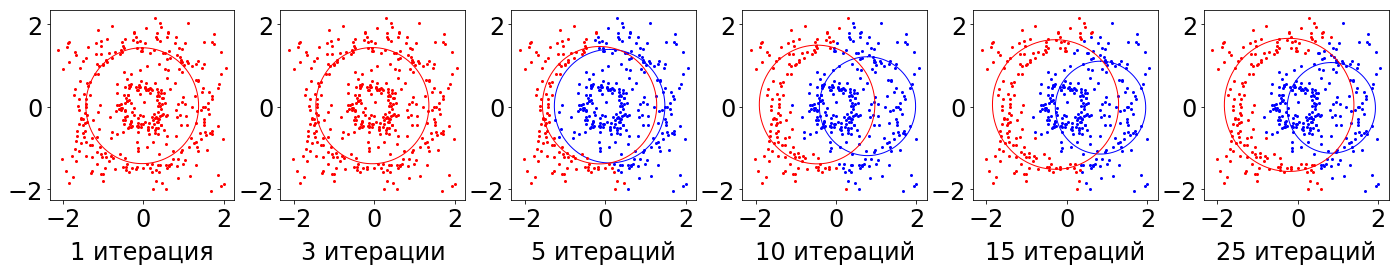

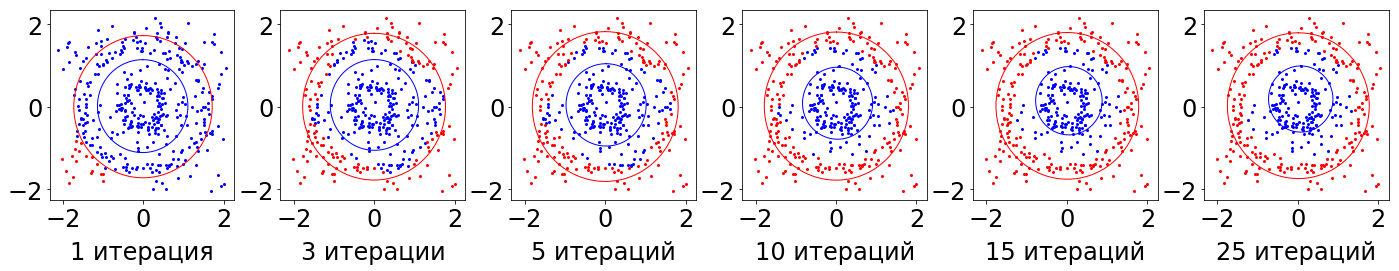

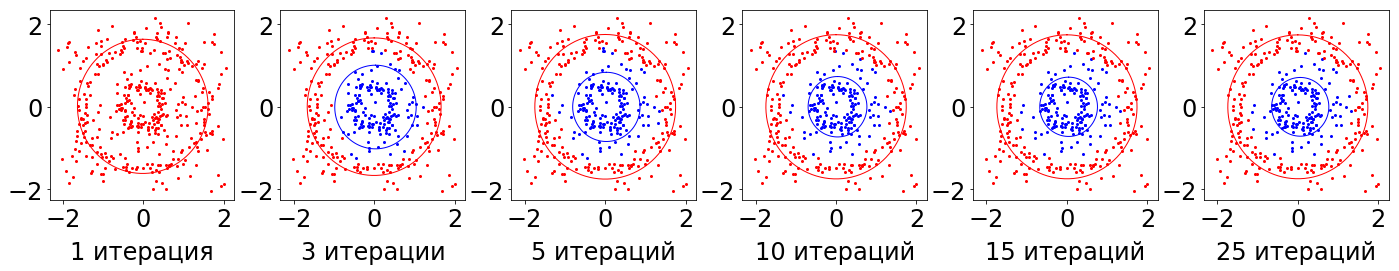

In [32]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 3.5)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

epochs = [1, 3, 5, 10, 15, 25]

t = np.linspace(0, 2*np.pi, 100)

colors = color

    
if lang == 'eng':
    rows = ['With prior regular', 'With prior', 'Without prior']
elif lang == 'ru':
    rows = ['Без задания априорного распределения', 'C заданием априорного распределения на модели', 'Регуляризация априорных распределений']  

if lang == 'eng':
    cols = [str(e) + 'epoch' for e in epochs]
elif lang == 'ru':
    cols = ['1 итерация', '3 итерации', '5 итераций', '10 итераций', '15 итераций', '25 итераций']


# -----------------1---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(epochs)):
    ax.append(fig.add_subplot(gs[k]))
    
for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)

List_of_step = [((List_of_circles_Not_Prior[0, k], List_of_idxs_Not_Prior[0, k]), k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])


plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('./' + folder_result + '/experiment_synt_not_prior_progress.pdf', bbox_inches='tight')
plt.show()    
    
# -----------------2---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(epochs)):
    ax.append(fig.add_subplot(gs[k]))

for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)
    
List_of_step = [((List_of_circles_Prior[0, k], List_of_idxs_Prior[0, k]), k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('./' + folder_result + '/experiment_synt_prior_progress.pdf', bbox_inches='tight')
plt.show()

# -----------------3---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(epochs)):
    ax.append(fig.add_subplot(gs[k]))

for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)
    
List_of_step = [((List_of_circles_Prior_Regular[0, k], List_of_idxs_Prior_Regular[0, k]), k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('./' + folder_result + '/experiment_synt_regular_progress.pdf', bbox_inches='tight')
plt.show()

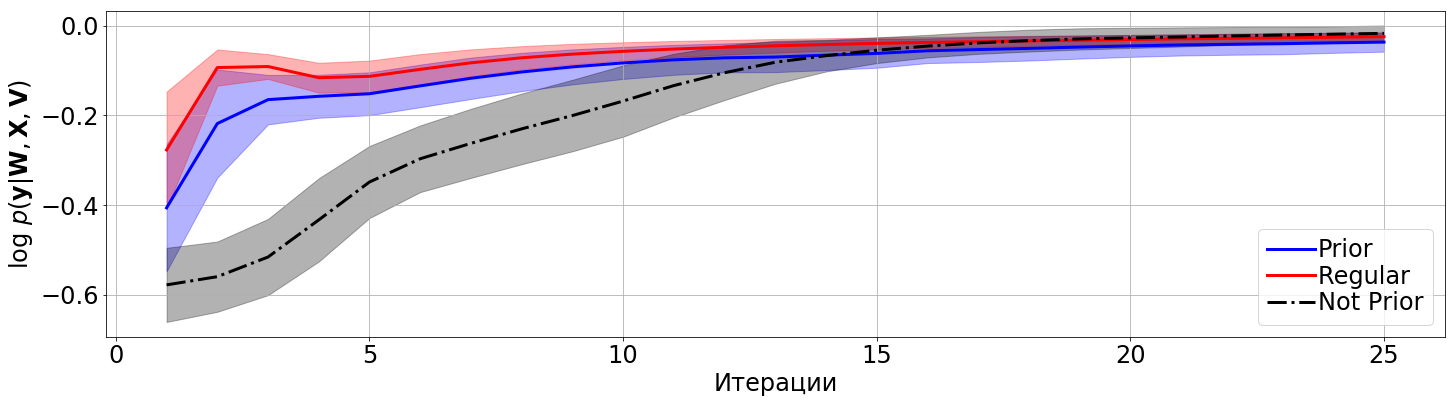

In [73]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 6)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

colors = color

KKK = 1
mean = List_of_log_likehood_Prior_mean[KKK:]
std = List_of_log_likehood_Prior_std[KKK:]
X_STEP_PLOT = np.arange(KKK, len(mean) + KKK, 1)
_ = plt.plot(X_STEP_PLOT, mean, '-', label = 'Prior', color = colors[0])
_ = plt.fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[0], alpha = 0.3)

mean = List_of_log_likehood_Prior_Regular_mean[KKK:]
std = List_of_log_likehood_Prior_Regular_std[KKK:]
X_STEP_PLOT = np.arange(KKK, len(mean) + KKK, 1)
_ = plt.plot(X_STEP_PLOT, mean, '-', label = 'Regular', color = colors[1])
_ = plt.fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[1], alpha = 0.3)

mean = List_of_log_likehood_Not_Prior_mean[KKK:]
std = List_of_log_likehood_Not_Prior_std[KKK:]
X_STEP_PLOT = np.arange(KKK, len(mean) + KKK, 1)
_ = plt.plot(X_STEP_PLOT, mean, '-.', label = 'Not Prior', color = colors[2])
_ = plt.fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[2], alpha = 0.3)

plt.legend(loc='best')
plt.grid()

if lang == 'eng':
    plt.xlabel('Epoch')
elif lang == 'ru':
    plt.xlabel('Итерации')
    
if lang == 'eng':
    plt.ylabel('$\log p(y|w, x)$')
elif lang == 'ru':
    plt.ylabel('$\log\ p(\mathbf{y}|\mathbf{W}, \mathbf{X}, \mathbf{V})$')

plt.savefig('./' + folder_result + '/experiment_synt_likelihood_progress.pdf', bbox_inches='tight')
plt.show()

# All

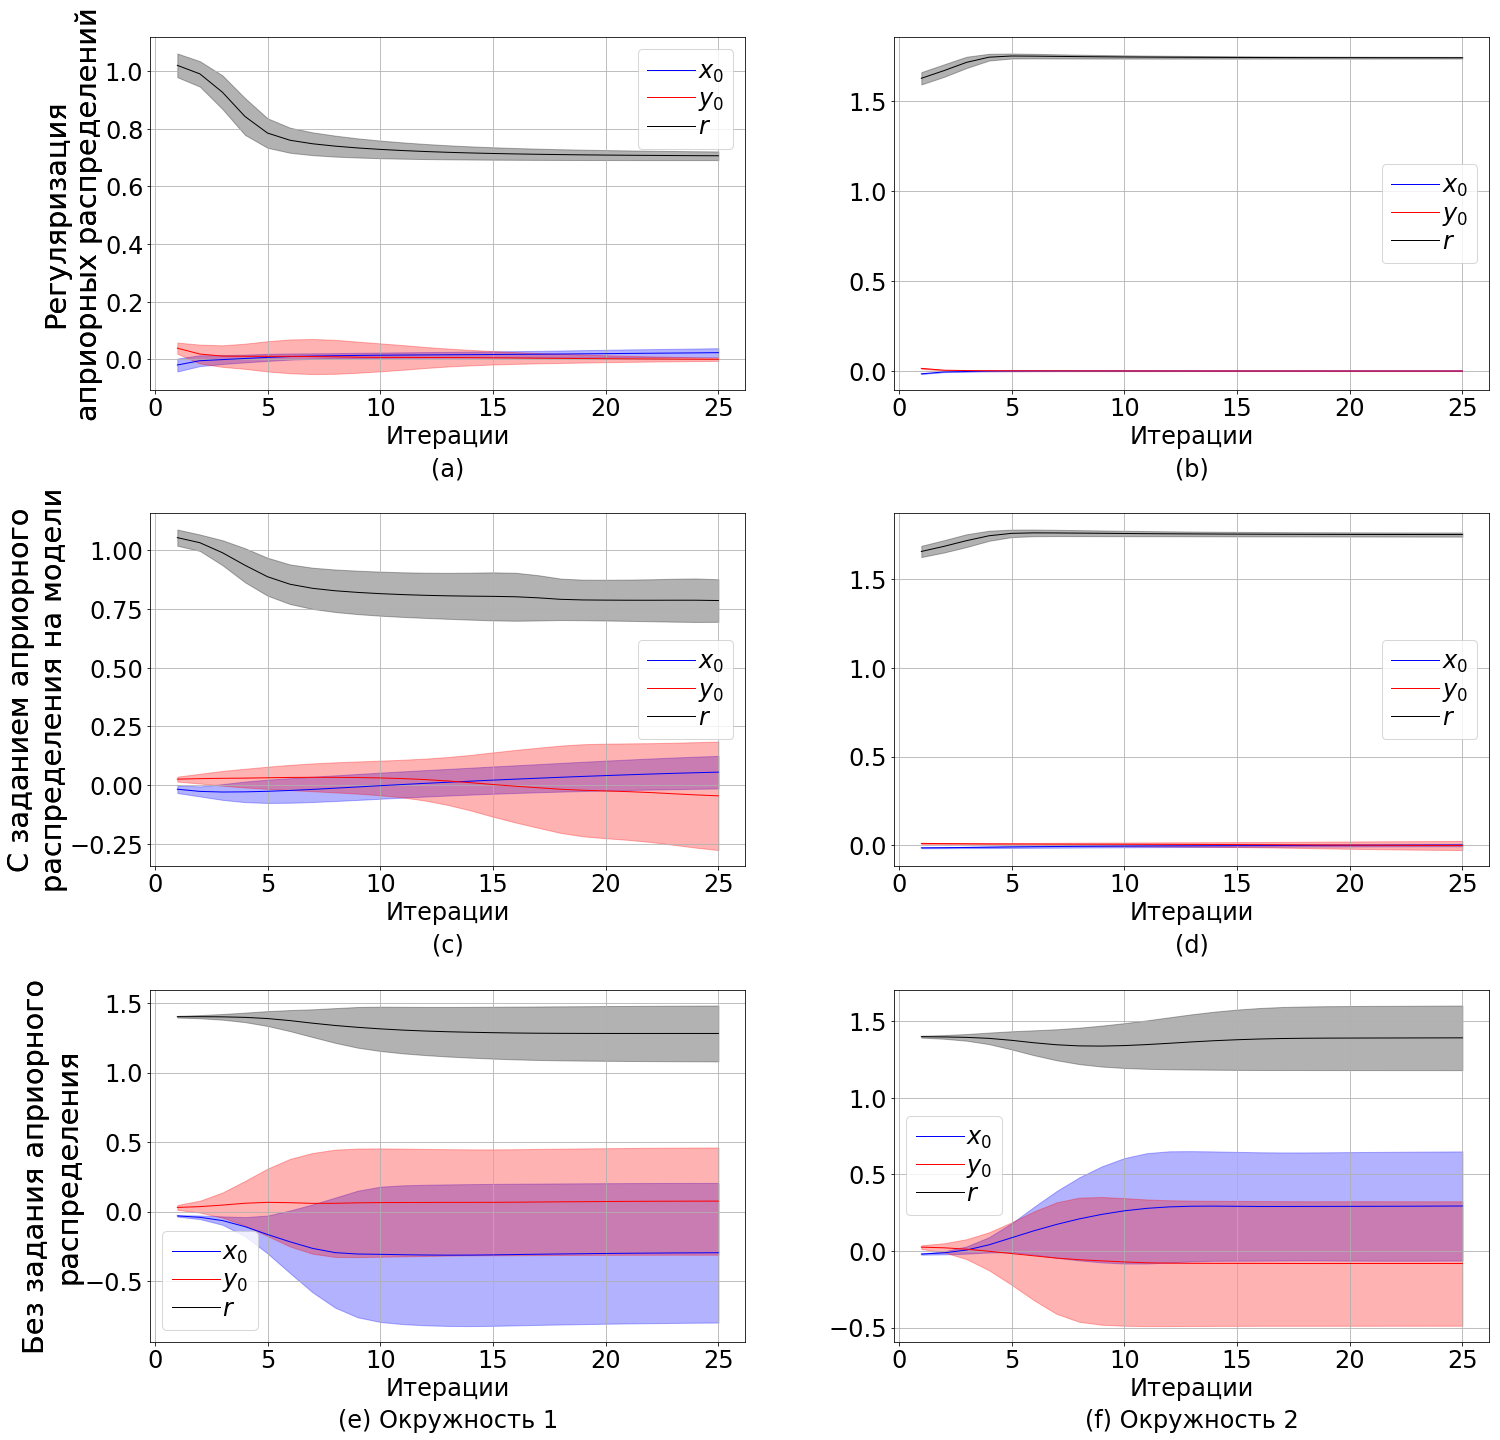

In [72]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 24.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

colors = color


fig = plt.figure();

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1])

ax1 = [] 
for k in range(2):
    ax1.append(fig.add_subplot(gs[k]))
    
ax2 = [] 
for k in range(2, 4):
    ax2.append(fig.add_subplot(gs[k]))
    
ax3 = [] 
for k in range(4, 6):
    ax3.append(fig.add_subplot(gs[k]))
    
if lang == 'eng':
    cols = ['Circle 1', 'Circle 2']
elif lang == 'ru':
    cols = ['Окружность 1', 'Окружность 2']
    
if lang == 'eng':
    rows = ['With prior regular', 'With prior', 'Without prior']
elif lang == 'ru':
    rows = ['Регуляризация\nаприорных распределений', 'C заданием априорного\nраспределения на модели', 'Без задания априорного\nраспределения']  


#------___1___------
TITLE = ['(a)', '(b)']

MEAN=List_of_circles_Prior_Regular.mean(axis=0)
STD=List_of_circles_Prior_Regular.std(axis=0)

Labels=['$x_0$', '$y_0$', '$r$']
KKK=1
for t in range(MEAN.shape[1]):
    
    ax1[t].set_xlabel('Итерации')
    
    for k in range(MEAN.shape[2]):
        mean = MEAN[KKK:, t, k]
        std = STD[KKK:, t, k]
        X_STEP_PLOT = np.arange(KKK, len(mean) + KKK, 1)
        _ = ax1[t].plot(X_STEP_PLOT, mean, '-', label = Labels[k], color = colors[k])
        _ = ax1[t].fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[k], alpha = 0.3)
    
    ax1[t].legend(loc='best')
    ax1[t].set_title(TITLE[t], y=-0.26)
    ax1[0].annotate(rows[0], xy=(0, 0.5), xytext=(-ax1[0].yaxis.labelpad - 24, 0),
                    xycoords=ax1[0].yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90)
    ax1[t].grid()
    
#------___2___------
TITLE = ['(c)', '(d)']

MEAN=List_of_circles_Prior.mean(axis=0)
STD=List_of_circles_Prior.std(axis=0)

Labels=['$x_0$', '$y_0$', '$r$']
KKK=1
for t in range(MEAN.shape[1]):
    ax2[t].set_xlabel('Итерации')
    for k in range(MEAN.shape[2]):
        mean = MEAN[KKK:, t, k]
        std = STD[KKK:, t, k]
        X_STEP_PLOT = np.arange(KKK, len(mean) + KKK, 1)
        _ = ax2[t].plot(X_STEP_PLOT, mean, '-', label = Labels[k], color = colors[k])
        _ = ax2[t].fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[k], alpha = 0.3)
    
    ax2[t].legend(loc='best')
    ax2[t].set_title(TITLE[t], y=-0.26)
    ax2[0].annotate(rows[1], xy=(0, 0.5), xytext=(-ax2[0].yaxis.labelpad - 24, 0),
                    xycoords=ax2[0].yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90)
    ax2[t].grid()
    
#------___3___------
TITLE = ['(e)', '(f)']

MEAN=List_of_circles_Not_Prior.mean(axis=0)
STD=List_of_circles_Not_Prior.std(axis=0)

Labels=['$x_0$', '$y_0$', '$r$']
KKK=1
for t in range(MEAN.shape[1]):
    ax3[t].set_xlabel('Итерации')
    for k in range(MEAN.shape[2]):
        mean = MEAN[KKK:, t, k]
        std = STD[KKK:, t, k]
        X_STEP_PLOT = np.arange(KKK, len(mean) + KKK, 1)
        _ = ax3[t].plot(X_STEP_PLOT, mean, '-', label = Labels[k], color = colors[k])
        _ = ax3[t].fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[k], alpha = 0.3)
    
    ax3[t].legend(loc='best')
    ax3[t].set_title(TITLE[t] + ' ' + cols[t], y=-0.26)
    ax3[0].annotate(rows[2], xy=(0, 0.5), xytext=(-ax3[0].yaxis.labelpad - 24, 0),
                    xycoords=ax3[0].yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90)
    ax3[t].grid()

plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig('./' + folder_result + '/experiment_synthetic_param_progress.pdf', bbox_inches='tight')

plt.show()

# Experiment with noise change

In [76]:
List_OF_Noise = np.arange(0, 200, 20)
List_OF_Noise

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180])

In [78]:
List_of_datasets = []

In [79]:
np.random.seed(0)
N = 100
n = 3
r1 = 0.5
r2 = 1.5
phi = np.linspace(0, 2*np.pi, N)

x0 = 0
y0 = 0

x_circs = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0])
y_circs = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0])

N_noise=200
for N_noise in List_OF_Noise:
    # x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0])
    x = np.hstack([x_circs, 4*(np.random.rand(N_noise)-0.5) + x0])
    x += 0.1*np.random.randn(x.shape[0])
    # y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0])
    y = np.hstack([y_circs, 4*(np.random.rand(N_noise)-0.5) + y0])
    y += 0.1*np.random.randn(y.shape[0])
    
    X = np.vstack([x, y, np.ones_like(x)]).T
    Y = x**2+y**2

    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])

    X_tr.shape, Y_tr.shape
    
    List_of_datasets.append((X_tr, Y_tr))

In [145]:
K = 2
n = 3

epoch = 25

k_for_meaning = 10

In [146]:
# %%time

# List_of_log_likehoods_Not_Prior_noise = []
# List_of_circles_Not_Prior_noise = []
# List_of_idxs_Not_Prior_noise = []

# for k in tqdm(range(k_for_meaning)):
#     List_of_log_likehoods_Not_Prior_noise_one = []
#     List_of_circles_Not_Prior_noise_one = []
#     List_of_idxs_Not_Prior_noise_one = []
    
#     for X_tr, Y_tr in tqdm(List_of_datasets, leave=False):
#         LoM = []
#         for k in range(K):
#             LoM.append(EachModelLinear(input_dim = n, device = device))

#         HypPar = {'beta': 1}

#         HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

#         model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)

#         model.fit(X_tr, Y_tr, epoch, progress = None)
#         List_of_log_likehoods_Not_Prior_noise_one.append(log_likelihood(Y_tr, X_tr, model))
#         CIRCLES, IDX = extract_picture(model, only_circ=False)
#         List_of_circles_Not_Prior_noise_one.append(CIRCLES)
#         List_of_idxs_Not_Prior_noise_one.append(IDX)
        
#     List_of_log_likehoods_Not_Prior_noise_one=np.array(List_of_log_likehoods_Not_Prior_noise_one)
#     List_of_circle_Not_Prior_noise_one=np.array(List_of_circles_Not_Prior_noise_one)
#     List_of_idx_Not_Prior_noise_one=np.array(List_of_idxs_Not_Prior_noise_one)
    
#     List_of_log_likehoods_Not_Prior_noise.append(List_of_log_likehoods_Not_Prior_noise_one)
#     List_of_circles_Not_Prior_noise.append(List_of_circle_Not_Prior_noise_one)
#     List_of_idxs_Not_Prior_noise.append(List_of_idx_Not_Prior_noise_one)
    
# pickle.dump([List_of_log_likehoods_Not_Prior_noise, List_of_circles_Not_Prior_noise, List_of_idxs_Not_Prior_noise], open('./dump/no_prior_noise_exp.pkl', 'wb'))


CPU times: user 2h 18min 20s, sys: 1min 29s, total: 2h 19min 49s
Wall time: 2h 20min 33s


In [147]:
List_of_log_likehoods_Not_Prior_noise, List_of_circles_Not_Prior_noise, List_of_idxs_Not_Prior_noise = pickle.load(open('./dump/no_prior_noise_exp.pkl', 'rb'))


In [148]:
# %%time

# LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
# LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]

# List_of_log_likehoods_Prior_noise = []
# List_of_circles_Prior_noise = []
# List_of_idxs_Prior_noise = []

# for k in tqdm(range(k_for_meaning)):
#     List_of_log_likehoods_Prior_noise_one = []
#     List_of_circles_Prior_noise_one = []
#     List_of_idxs_Prior_noise_one = []

#     for X_tr, Y_tr in tqdm(List_of_datasets, leave=False):
#         LoM = []
#         for k in range(K):
#             LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

#         HypPar = {'beta': 1.0, 'alpha': 1e-5}

#         HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

#         model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)
    
#         model.fit(X_tr, Y_tr, epoch, progress = None)
#         List_of_log_likehoods_Prior_noise_one.append(log_likelihood(Y_tr, X_tr, model))
#         CIRCLES, IDX = extract_picture(model, only_circ=False)
#         List_of_circles_Prior_noise_one.append(CIRCLES)
#         List_of_idxs_Prior_noise_one.append(IDX)
        
#     List_of_log_likehoods_Prior_noise_one=np.array(List_of_log_likehoods_Prior_noise_one)
#     List_of_circle_Prior_noise_one=np.array(List_of_circles_Prior_noise_one)
#     List_of_idx_Prior_noise_one=np.array(List_of_idxs_Prior_noise_one)
    
#     List_of_log_likehoods_Prior_noise.append(List_of_log_likehoods_Prior_noise_one)
#     List_of_circles_Prior_noise.append(List_of_circle_Prior_noise_one)
#     List_of_idxs_Prior_noise.append(List_of_idx_Prior_noise_one)
    
# pickle.dump([List_of_log_likehoods_Prior_noise, List_of_circles_Prior_noise, List_of_idxs_Prior_noise], open('./dump/prior_noise_exp.pkl', 'wb'))



CPU times: user 2h 22min 42s, sys: 1min 48s, total: 2h 24min 30s
Wall time: 2h 26min 18s


In [149]:
List_of_log_likehoods_Prior_noise, List_of_circles_Prior_noise, List_of_idxs_Prior_noise = pickle.load(open('./dump/prior_noise_exp.pkl', 'rb'))


In [150]:
# %%time

# LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
# LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]

# List_of_log_likehoods_Prior_Regular_noise = []
# List_of_circles_Prior_Regular_noise = []
# List_of_idxs_Prior_Regular_noise = []

# for k in tqdm(range(k_for_meaning)):
#     List_of_log_likehoods_Prior_Regular_noise_one = []
#     List_of_circles_Prior_Regular_noise_one = []
#     List_of_idxs_Prior_Regular_noise_one = []
    
#     for X_tr, Y_tr in tqdm(List_of_datasets, leave=False):
#         LoM = []
#         for k in range(K):
#             LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

#         HypPar = {'beta': 1.0, 'alpha': 1e-5}

#         HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)
#         Rg = RegularizeModel(ListOfModels = LoM, device = device)
#         model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [Rg], device = device)
    
#         model.fit(X_tr, Y_tr, epoch, progress = None)
#         List_of_log_likehoods_Prior_Regular_noise_one.append(log_likelihood(Y_tr, X_tr, model))
#         CIRCLES, IDX = extract_picture(model, only_circ=False)
#         List_of_circles_Prior_Regular_noise_one.append(CIRCLES)
#         List_of_idxs_Prior_Regular_noise_one.append(IDX)
        
#     List_of_log_likehoods_Prior_Regular_noise_one=np.array(List_of_log_likehoods_Prior_Regular_noise_one)
#     List_of_circle_Prior_Regular_noise_one=np.array(List_of_circles_Prior_Regular_noise_one)
#     List_of_idx_Prior_Regular_noise_one=np.array(List_of_idxs_Prior_Regular_noise_one)
    
#     List_of_log_likehoods_Prior_Regular_noise.append(List_of_log_likehoods_Prior_Regular_noise_one)
#     List_of_circles_Prior_Regular_noise.append(List_of_circle_Prior_Regular_noise_one)
#     List_of_idxs_Prior_Regular_noise.append(List_of_idx_Prior_Regular_noise_one)
    
# pickle.dump([List_of_log_likehoods_Prior_Regular_noise, List_of_circles_Prior_Regular_noise, List_of_idxs_Prior_Regular_noise], open('./dump/prior_regular_noise_exp.pkl', 'wb'))




CPU times: user 2h 13min 32s, sys: 1min 6s, total: 2h 14min 39s
Wall time: 2h 14min 42s


In [151]:
List_of_log_likehoods_Prior_Regular_noise, List_of_circles_Prior_Regular_noise, List_of_idxs_Prior_Regular_noise = pickle.load(open('./dump/prior_regular_noise_exp.pkl', 'rb'))


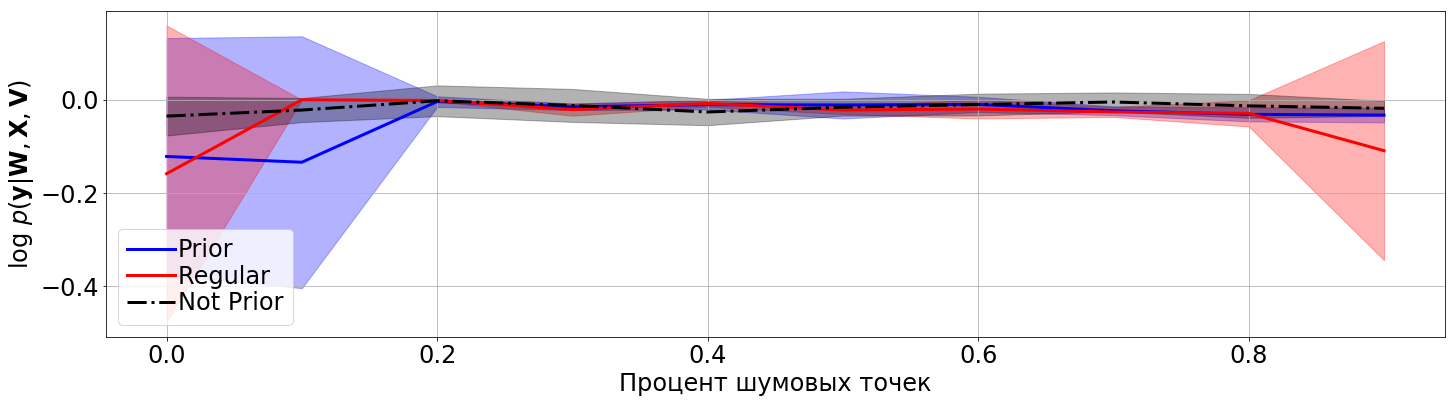

In [152]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 6)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

colors = color

KKK = 0
mean = np.array(List_of_log_likehoods_Prior_noise).mean(axis=0)[KKK:]
std = np.array(List_of_log_likehoods_Prior_noise).std(axis=0)[KKK:]
X_STEP_PLOT = np.array(List_OF_Noise)/200
_ = plt.plot(X_STEP_PLOT, mean, '-', label = 'Prior', color = colors[0])
_ = plt.fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[0], alpha = 0.3)

mean = np.array(List_of_log_likehoods_Prior_Regular_noise).mean(axis=0)[KKK:]
std = np.array(List_of_log_likehoods_Prior_Regular_noise).std(axis=0)[KKK:]
X_STEP_PLOT = np.array(List_OF_Noise)/200
_ = plt.plot(X_STEP_PLOT, mean, '-', label = 'Regular', color = colors[1])
_ = plt.fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[1], alpha = 0.3)

mean = np.array(List_of_log_likehoods_Not_Prior_noise).mean(axis=0)[KKK:]
std = np.array(List_of_log_likehoods_Not_Prior_noise).std(axis=0)[KKK:]
X_STEP_PLOT = np.array(List_OF_Noise)/200
_ = plt.plot(X_STEP_PLOT, mean, '-.', label = 'Not Prior', color = colors[2])
_ = plt.fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[2], alpha = 0.3)

plt.legend(loc='best')
plt.grid()

if lang == 'eng':
    plt.xlabel('Pecentage of noise')
elif lang == 'ru':
    plt.xlabel('Процент шумовых точек')
    
if lang == 'eng':
    plt.ylabel('$\log p(y|w, x)$')
elif lang == 'ru':
    plt.ylabel('$\log\ p(\mathbf{y}|\mathbf{W}, \mathbf{X}, \mathbf{V})$')

plt.savefig('./' + folder_result + '/experiment_synt_likelihood_progress_noise.pdf', bbox_inches='tight')
plt.show()

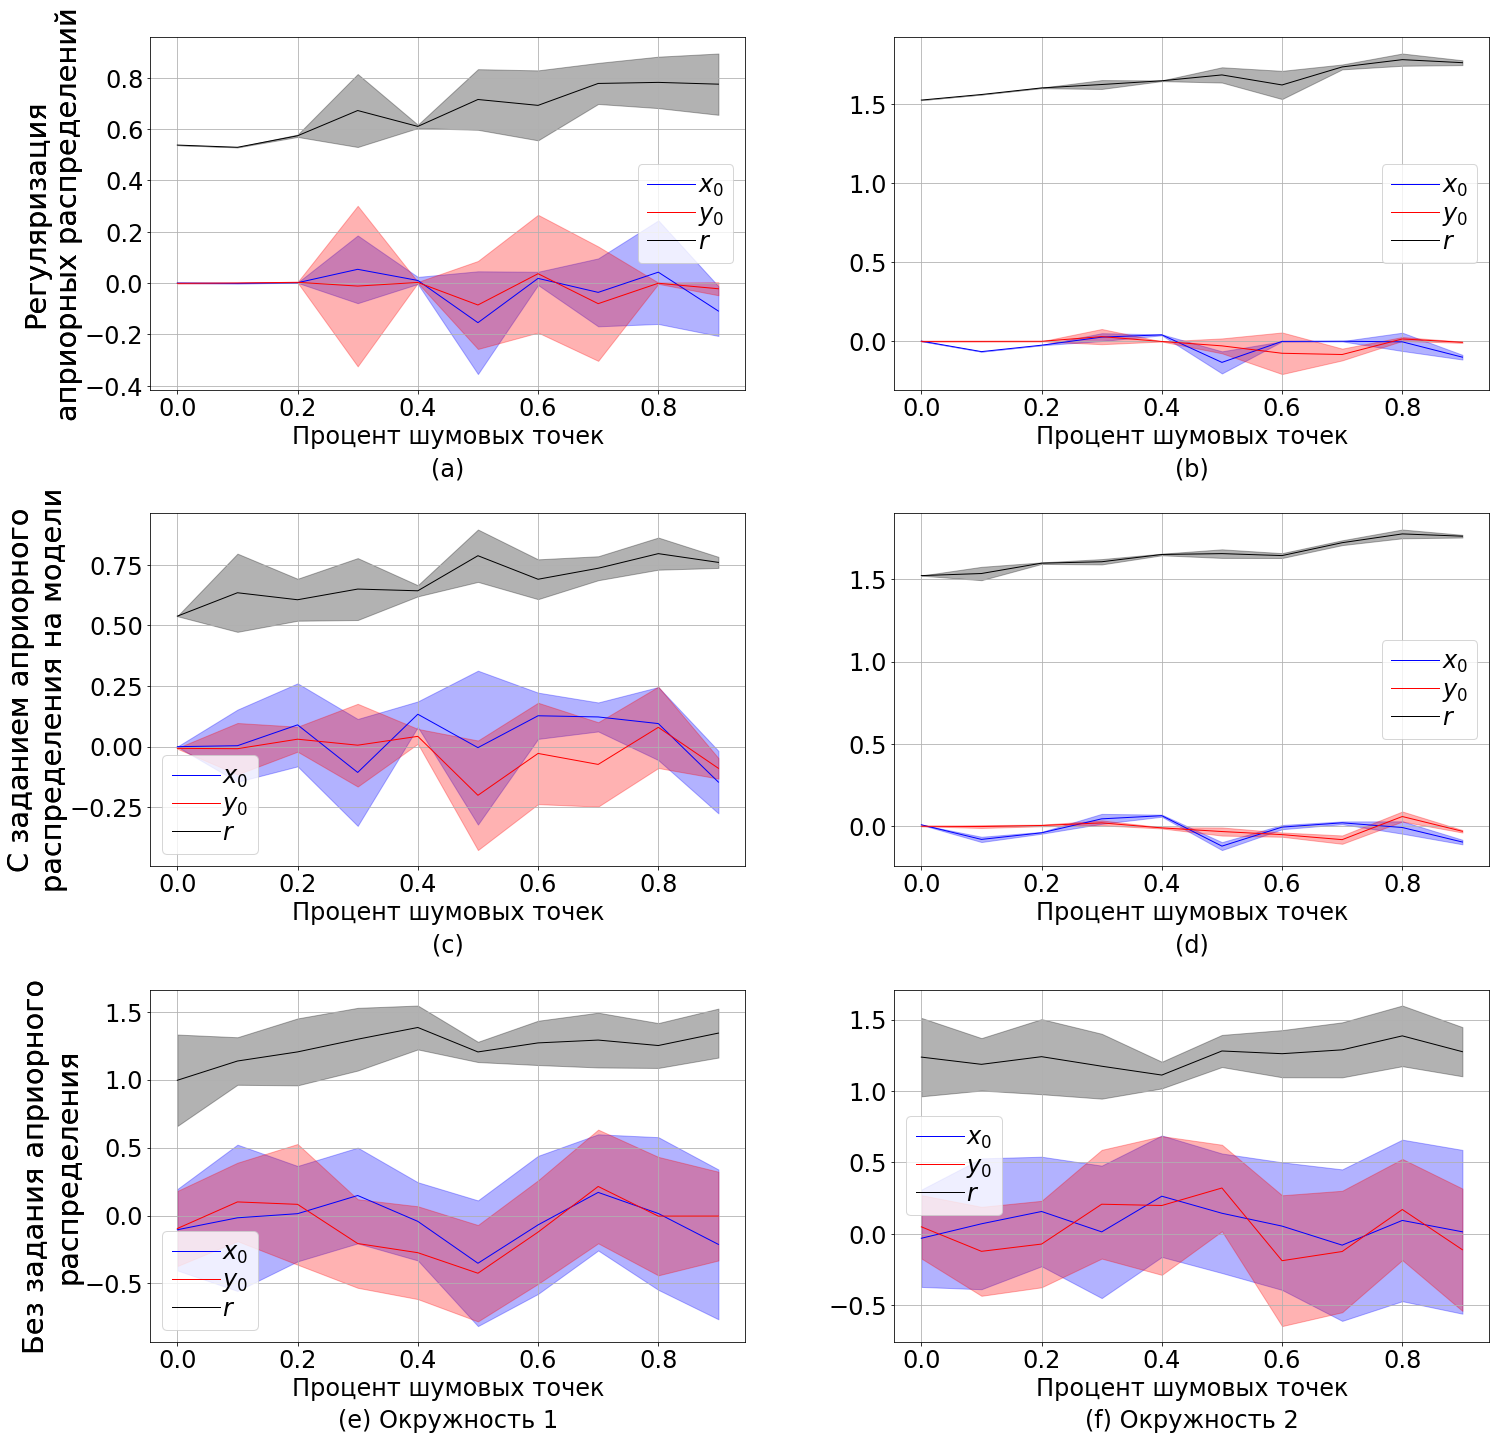

In [153]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 24.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

colors = color


fig = plt.figure();

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1])

ax1 = [] 
for k in range(2):
    ax1.append(fig.add_subplot(gs[k]))
    
ax2 = [] 
for k in range(2, 4):
    ax2.append(fig.add_subplot(gs[k]))
    
ax3 = [] 
for k in range(4, 6):
    ax3.append(fig.add_subplot(gs[k]))
    
if lang == 'eng':
    cols = ['Circle 1', 'Circle 2']
elif lang == 'ru':
    cols = ['Окружность 1', 'Окружность 2']
    
if lang == 'eng':
    rows = ['With prior regular', 'With prior', 'Without prior']
elif lang == 'ru':
    rows = ['Регуляризация\nаприорных распределений', 'C заданием априорного\nраспределения на модели', 'Без задания априорного\nраспределения']  


#------___1___------
TITLE = ['(a)', '(b)']

MEAN=np.array(List_of_circles_Prior_Regular_noise).mean(axis=0)
STD=np.array(List_of_circles_Prior_Regular_noise).std(axis=0)

Labels=['$x_0$', '$y_0$', '$r$']
KKK=0
for t in range(MEAN.shape[1]):
    if lang == 'eng':
        ax1[t].set_xlabel('Pecentage of noise')
    elif lang == 'ru':
        ax1[t].set_xlabel('Процент шумовых точек')
    for k in range(MEAN.shape[2]):
        mean = MEAN[KKK:, t, k]
        std = STD[KKK:, t, k]
        X_STEP_PLOT = np.array(List_OF_Noise)/200
        _ = ax1[t].plot(X_STEP_PLOT, mean, '-', label = Labels[k], color = colors[k])
        _ = ax1[t].fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[k], alpha = 0.3)
    
    ax1[t].legend(loc='best')
    ax1[t].set_title(TITLE[t], y=-0.26)
    ax1[0].annotate(rows[0], xy=(0, 0.5), xytext=(-ax1[0].yaxis.labelpad - 24, 0),
                    xycoords=ax1[0].yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90)
    ax1[t].grid()
    
#------___2___------
TITLE = ['(c)', '(d)']

MEAN=np.array(List_of_circles_Prior_noise).mean(axis=0)
STD=np.array(List_of_circles_Prior_noise).std(axis=0)

Labels=['$x_0$', '$y_0$', '$r$']
KKK=0
for t in range(MEAN.shape[1]):
    if lang == 'eng':
        ax2[t].set_xlabel('Pecentage of noise')
    elif lang == 'ru':
        ax2[t].set_xlabel('Процент шумовых точек')
    for k in range(MEAN.shape[2]):
        mean = MEAN[KKK:, t, k]
        std = STD[KKK:, t, k]
        X_STEP_PLOT = np.array(List_OF_Noise)/200
        _ = ax2[t].plot(X_STEP_PLOT, mean, '-', label = Labels[k], color = colors[k])
        _ = ax2[t].fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[k], alpha = 0.3)
    
    ax2[t].legend(loc='best')
    ax2[t].set_title(TITLE[t], y=-0.26)
    ax2[0].annotate(rows[1], xy=(0, 0.5), xytext=(-ax2[0].yaxis.labelpad - 24, 0),
                    xycoords=ax2[0].yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90)
    ax2[t].grid()
    
#------___3___------
TITLE = ['(e)', '(f)']

MEAN=np.array(List_of_circles_Not_Prior_noise).mean(axis=0)
STD=np.array(List_of_circles_Not_Prior_noise).std(axis=0)

Labels=['$x_0$', '$y_0$', '$r$']
KKK=0
for t in range(MEAN.shape[1]):
    if lang == 'eng':
        ax3[t].set_xlabel('Pecentage of noise')
    elif lang == 'ru':
        ax3[t].set_xlabel('Процент шумовых точек')
    for k in range(MEAN.shape[2]):
        mean = MEAN[KKK:, t, k]
        std = STD[KKK:, t, k]
        X_STEP_PLOT = np.array(List_OF_Noise)/200
        _ = ax3[t].plot(X_STEP_PLOT, mean, '-', label = Labels[k], color = colors[k])
        _ = ax3[t].fill_between(X_STEP_PLOT, mean-std, mean+std, color = colors[k], alpha = 0.3)
    
    ax3[t].legend(loc='best')
    ax3[t].set_title(TITLE[t] + ' ' + cols[t], y=-0.26)
    ax3[0].annotate(rows[2], xy=(0, 0.5), xytext=(-ax3[0].yaxis.labelpad - 24, 0),
                    xycoords=ax3[0].yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90)
    ax3[t].grid()

plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig('./' + folder_result + '/experiment_synthetic_param_progress_noise.pdf', bbox_inches='tight')

plt.show()